# Import

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100


ModuleNotFoundError: No module named 'mendeleev'


# Function that sets up HNC QSP 

### Create and run plasma

In [9]:
name='C'
Z, A = 6, 12
mi = m_p * A

ni_cc = 5.01e23
ri_cm = rs_from_n(ni_cc)
ri_AU = ri_cm*cm_to_AU


### Make βu_ii, βu_fi from using bound density from AA
If we assume the bound state does not deform at all, then we can calculate potentials based on it easily via integration

### Solving

In [10]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

def custom_flat(hnc_matrix):
    hnc_flat = np.concatenate([hnc_matrix[0,0],hnc_matrix[0,1],hnc_matrix[1,1]])
    return hnc_flat

def custom_unflat(hnc_flat):
    hnc00, hnc01, hnc11 = np.split(hnc_flat,3)
    hnc_matrix = np.zeros((2,2,len(hnc00)))
    hnc_matrix[0,0] = hnc00
    hnc_matrix[1,0] = hnc01
    hnc_matrix[0,1] = hnc01
    hnc_matrix[1,1] = hnc11
    return hnc_matrix

def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None, ftol=1e-8):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    get_sparse_csk = lambda c_s_k_flat: np.concatenate([interp1d(plasma.hnc.k_array, c_s_k)(sparse_k_array) for c_s_k in np.split(c_s_k_flat,3) ])
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='cubic')(plasma.hnc.k_array)
    get_csk_matrix_from_sparse_csk_flat =  lambda sparse_c_s_k_flat: custom_unflat(np.concatenate([get_csk(sparse_csk) for sparse_csk in np.split(sparse_c_s_k_flat,3)]))
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sparse_c_s_k_flat)
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.hnc.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = custom_flat(new_c_s_k_matrix)
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = custom_flat(c_s_k_guess)
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    plasma.hnc.c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sol.x)
    plasma.hnc.set_all_matrices_from_csk(plasma.hnc.c_s_k_matrix)
    print(sol)

def best_shift(plasma, c_s_k_guess = None, ftol=1e-8, set=True):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    def min_function(multiplier_list):
        xii, xei, xee = multiplier_list
        multiplier_matrix = np.array([[xii,xei],[xei,xee]])
        c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * c_s_k_guess
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        
        return c_s_k_matrix.flatten() - new_c_s_k_matrix.flatten()
    
    sol = least_squares(min_function, np.ones((3)) , verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    xii, xei, xee = sol.x
    multiplier_matrix = np.array([[xii,xei],[xei,xee]])
    
    plasma.hnc.c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * c_s_k_guess
    print(sol)
    return sol

In [11]:
def make_Ashcroft_βvei(atom, α=1, Rc = 0.4):
    # Assumes Rc in terms of Wigner-Seitz radius already as are hnc units
    k = atom.hnc.k_array
    βvei= atom.hnc.FT_k_2_r(  4*π*atom.qsp.Γei* (np.cos(k*Rc)*(1-α) + α*np.sin(k*Rc)/(k*Rc)) * (1/k**2 - 1/(k**2 + 1/atom.qsp.Λei**2)) )
    atom.hnc.βu_r_matrix[0,1] = βvei
    atom.hnc.βu_r_matrix[1,0] = βvei
    atom.hnc.set_βu_matrix(atom.hnc.βu_r_matrix)

In [12]:
def plasma_f(T_eV, Rc, Zbar, closure='svt'):
    plasma = PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options = {'Te_c_type':'DMC'},
             hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':closure},
             hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':2000},
             root_options={'options':{'maxfev':100,'xtol':1e-14}})
    
    # Make the smoothed Ashcroft potential 
    make_Ashcroft_βvei(plasma, α=0, Rc = Rc)
    
    return plasma

In [13]:
def ocp_f(T_eV, Zbar):
    ocp = PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':2000},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
    ocp.run_ocp_hnc()
    return ocp

def yp_f(T_eV, Zbar):
    yukawa_plasma =  PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':2000},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
    yukawa_plasma.run_yukawa_hnc();
    return yukawa_plasma

In [14]:
def save_plasma(plasma, Rc):
    T_eV = plasma.Ti_eV
    Zbar = plasma.qsp.Zbar
    ocp = ocp_f( T_eV, Zbar)
    yp  = yp_f(T_eV, Zbar )
    
    # Make header
    info_header = (f"# Zach Johnson Dec/11/2023 CHNC for TCCW Paper" + '\n' + 
                   f"# Ti={T_eV:0.3e}[eV], Tie={plasma.qsp.Tie_c*AU_to_eV:0.3e}[eV] , Te_c={plasma.qsp.Te_c*AU_to_eV:0.3e}[eV], n_i={plasma.ni_cc:0.3e}[1/cc], n_e={Zbar*plasma.ni_cc:0.3e}[1/cc]" + '\n' + 
                   f"# ri={ri_AU:0.3f}, Zbar={Zbar:0.3f}, Rc={Rc:0.3f}[AU], Γii={plasma.qsp.Γii:0.3e}, Γei={plasma.qsp.Γei:0.3e} , Γee={plasma.qsp.Γee:0.3e}, κ={plasma.qsp.get_κ():0.3e}" 
                  )
    column_header = f"{'r/ri':10}  {'g_ii':10}  {'g_ei':10}  {'g_ee':10}  {'OCP:g_ii':10}  {'Yuk:g_ii':10}  {'βu_ii_eff':10}  {'βu_OCP':10}  {'βu_Yuk':10}"
    header = info_header + '\n' + column_header
    
    # Make save array
    save_array = np.array([  plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1, plasma.hnc.h_r_matrix[0,1]+1, plasma.hnc.h_r_matrix[1,1]+1,
                           ocp.ocp_hnc.h_r_matrix[0,0]+1, yp.yuk_hnc.h_r_matrix[0,0] + 1, plasma.hnc.βueff_r_matrix_with_B[0,0],
                           ocp.ocp_hnc.βu_r_matrix[0,0], yp.yuk_hnc.βu_r_matrix[0,0]]).T
    
    np.savetxt(f"/home/zach/plasma/hnc/TCCW/Final_TCCW/results/CHNC_C_rs{ri_AU:0.3f}_TeV{plasma.Ti_eV:0.3f}.dat", save_array, 
               header=header, fmt='%10.5e', comments='')

### Now Load Data from George
Rc is interpreted as the average bound radius, in AU in the file. Empty-core Ashcroft assumed.

In [15]:
GP_data   = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/GP_data/C_combined.dat", header=0, delim_whitespace=True)
T_eV_list = GP_data['Te(eV)']
Rc_list   = GP_data['Rc'] # AU
Zbar_list = GP_data['Z_bar'] #Average atom Zbar GP_data
GP_data

,Te(eV),rho/rho0,Ne_b,Ne_quasi,Ne_sc,Z_bar,Rc,mu,nu_mom,nu_tot,sigma,k_th,L,G
0,0.02,1.0,2.000,0.0,4.000,4.000,0.275,1.528000,0.3848,0.4311,0.4849,0.000281,0.787,0.000027
1,0.05,1.0,2.000,0.0,4.000,4.000,0.275,1.528000,0.3848,0.4309,0.3493,0.002046,3.188,0.000020
2,0.10,1.0,2.000,0.0,4.000,4.000,0.275,1.528000,0.3848,0.4307,0.3486,0.004138,3.230,0.000020
3,0.20,1.0,2.000,0.0,4.001,4.001,0.275,1.529000,0.3849,0.4303,0.3489,0.008291,3.234,0.000020
4,0.50,1.0,2.000,0.0,4.000,4.000,0.275,1.531000,0.3851,0.4288,0.3499,0.020820,3.239,0.000020
5,1.00,1.0,2.000,0.0,4.000,4.000,0.276,1.535000,0.3858,0.4267,0.3518,0.042090,3.255,0.000020
6,2.00,1.0,2.000,0.0,4.000,4.000,0.276,1.541000,0.3885,0.4242,0.3568,0.087180,3.325,0.000020
7,5.00,1.0,2.000,0.0,4.000,4.000,0.278,1.558000,0.4057,0.4275,0.3952,0.399500,5.502,0.000020
8,10.00,1.0,2.000,0.0,4.000,4.000,0.280,1.556000,0.4458,0.4529,1.0100,2.146000,5.784,0.000021
9,20.00,1.0,2.000,0.0,4.000,4.000,0.283,1.393000,0.5078,0.5134,1.3640,2.928000,2.920,0.000021


In [16]:
plasma_list = []

for T_eV, Rc, Zbar in zip(T_eV_list, Rc_list, Zbar_list):
    plasma = plasma_f(T_eV, Rc/ri_AU, Zbar )
    plasma_list.append(plasma)

Te_in_eV: 0.020
Ti_in_eV: 0.020
Te_in_eV: 0.050
Ti_in_eV: 0.050
Te_in_eV: 0.100
Ti_in_eV: 0.100
Te_in_eV: 0.200
Ti_in_eV: 0.200
Te_in_eV: 0.500
Ti_in_eV: 0.500
Te_in_eV: 1.000
Ti_in_eV: 1.000
Te_in_eV: 2.000
Ti_in_eV: 2.000
Te_in_eV: 5.000
Ti_in_eV: 5.000
Te_in_eV: 10.000
Ti_in_eV: 10.000
Te_in_eV: 20.000
Ti_in_eV: 20.000
Te_in_eV: 50.000
Ti_in_eV: 50.000
Te_in_eV: 100.000
Ti_in_eV: 100.000
Te_in_eV: 200.000
Ti_in_eV: 200.000
Te_in_eV: 500.000
Ti_in_eV: 500.000
Te_in_eV: 1000.000
Ti_in_eV: 1000.000


In [54]:
guess_c_s_k_matrix = None
for Rc, plasma in zip(Rc_list[:5][::-1], plasma_list[:5][::-1]): 
    print(f"T_eV = {plasma.Ti_eV}")

    # if T_eV == 2.0:
    plasma.run_hnc(c_s_k_guess = guess_c_s_k_matrix)
    if plasma.hnc.tot_err_list[-1] > 1e-7:
        best_shift(plasma)
        solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=200))
        solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=400))
        save_plasma(plasma, Rc)
    else:
        save_plasma(plasma, Rc)
    # guess_c_s_k_matrix = plasma.hnc.c_s_k_matrix.copy()

T_eV = 0.5
0: Initial condition Total Error: 4.685e+01
Starting Ng loop, using best index so far:  999
QUIT: Large Error at many iterations, and error not decreasing.
Exiting status 3, reverting to best index so far: 998
Final iter:1002, Total Error: 3.442e-01
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.7609e+01                                    5.58e+04    
       1              3         3.7895e+01      4.97e+01       1.99e-01       6.01e+03    
       2              5         3.6464e+01      1.43e+00       9.96e-02       1.97e+03    
       3              6         3.6190e+01      2.74e-01       9.96e-02       1.36e+03    
       4              8         3.6113e+01      7.70e-02       2.49e-02       2.90e+02    
       5             11         3.6110e+01      2.28e-03       1.56e-03       2.99e+01    
       6             12         3.6109e+01      1.83e-03       1.56e-03       1.71e+00    
       7   

### Plot and Comparison to QMD

In [ ]:

for plasma, Rc in zip(plasma_list[6:7], Rc_list[6:7]):    
    save_plasma(plasma, Rc)

# Carbon Final Plots

In [17]:
C1_GP = read_csv("GP_data/GP_C1_profile.dat", delim_whitespace=True, header=0)
C1_GP

,x,r,Vcoul,Vexc,V,rV,dNedr_b,dNedr_s,dNedr_f,dNedr,ne_b,ne_s,ne_f,ne
0,0.000113,0.000167,36000.000000,3.782000,3.600000e+04,6.001000e+00,0.000041,0.000000,0.000015,0.000041,117.000000,0.0000,42.0600,117.0000
1,0.000114,0.000168,35660.000000,3.852000,3.566000e+04,5.998000e+00,0.000042,0.000002,0.000015,0.000044,117.000000,5.8540,41.8600,122.9000
2,0.000115,0.000170,35340.000000,3.852000,3.534000e+04,5.998000e+00,0.000042,0.000002,0.000015,0.000044,117.000000,5.8540,41.6700,122.9000
3,0.000116,0.000171,35020.000000,3.852000,3.502000e+04,5.998000e+00,0.000043,0.000002,0.000015,0.000045,117.000000,5.8540,41.4800,122.9000
4,0.000117,0.000173,34700.000000,3.852000,3.470000e+04,5.998000e+00,0.000044,0.000002,0.000016,0.000046,117.000000,5.8540,41.2900,122.9000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.964290,1.426400,0.004076,0.006778,1.086000e-02,1.549000e-02,0.001228,5.909000,4.734000,5.910000,0.000048,0.2311,0.1852,0.2312
997,0.973100,1.439400,0.002293,0.005060,7.356000e-03,1.059000e-02,0.001113,5.960000,4.806000,5.961000,0.000043,0.2289,0.1846,0.2290
998,0.981980,1.452500,0.001019,0.003357,4.378000e-03,6.360000e-03,0.001009,6.012000,4.880000,6.013000,0.000038,0.2268,0.1841,0.2268
999,0.990950,1.465800,0.000255,0.001670,1.926000e-03,2.823000e-03,0.000915,6.065000,4.958000,6.066000,0.000034,0.2246,0.1836,0.2247


In [18]:
C1_CHNC = read_csv("results/CHNC_C_rs1.476_TeV2.000.dat", delim_whitespace=True, header=3)
C1_ri = 1.476
C1_Zbar = 4
C1_ne0 = C1_Zbar/(4/3*np.pi*C1_ri**3)
C1_CHNC

,r/ri,g_ii,g_ei,g_ee,OCP:g_ii,Yuk:g_ii,βu_ii_eff,βu_OCP,βu_Yuk
0,0.01,0.000000,1.496080,0.185865,2.418780e-08,0.000000,14571.500000,14755.4000,1.438090e+04
1,0.02,0.000000,1.502070,0.191831,2.414890e-08,0.000000,7197.600000,7381.5200,7.011530e+03
2,0.03,0.000000,1.512200,0.200022,2.408180e-08,0.000000,4739.680000,4923.5500,4.558050e+03
3,0.04,0.000000,1.526430,0.210421,2.398950e-08,0.000000,3510.770000,3694.5500,3.333470e+03
4,0.05,0.000000,1.545030,0.222966,2.387070e-08,0.000000,2773.480000,2957.1500,2.600420e+03
...,...,...,...,...,...,...,...,...,...
995,9.96,0.998593,0.999841,0.999985,9.949790e-01,0.999978,-0.000001,14.8071,1.868160e-10
996,9.97,0.998586,0.999840,0.999985,9.949510e-01,0.999977,-0.000001,14.7922,1.819850e-10
997,9.98,0.998581,0.999839,0.999985,9.949330e-01,0.999977,-0.000001,14.7774,1.772790e-10
998,9.99,0.998579,0.999839,0.999985,9.949240e-01,0.999977,-0.000001,14.7626,1.726950e-10


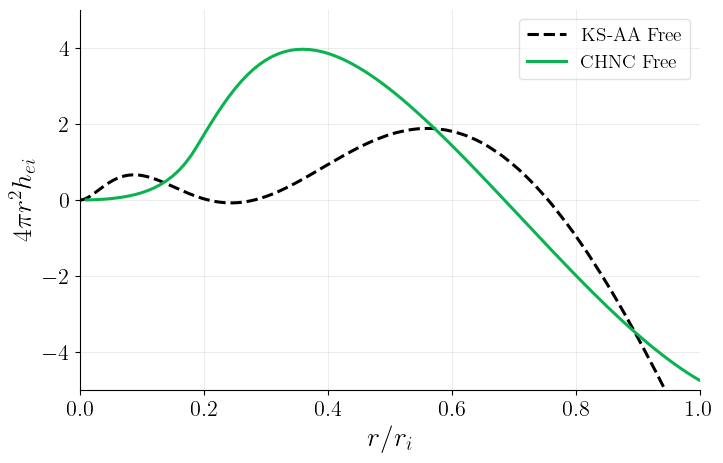

In [19]:
def g_ei_plot(ax):
    ax.plot(C1_GP['x'], (C1_GP['ne_s']/C1_ne0-1)*4*π*(C1_GP['r'])**2,'k--', label="KS-AA Free"  )
    ax.plot(C1_CHNC['r/ri'],(C1_CHNC['g_ei']-1)*4*π*(C1_CHNC['r/ri']*C1_ri)**2, label="CHNC Free"  )

    ax.set_xlim(0,1)
    ax.set_ylim(-5,5)
    ax.set_ylabel(r"$4\pi r^2 h_{ei}$")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()

fig, ax  = plt.subplots()
g_ei_plot(ax)

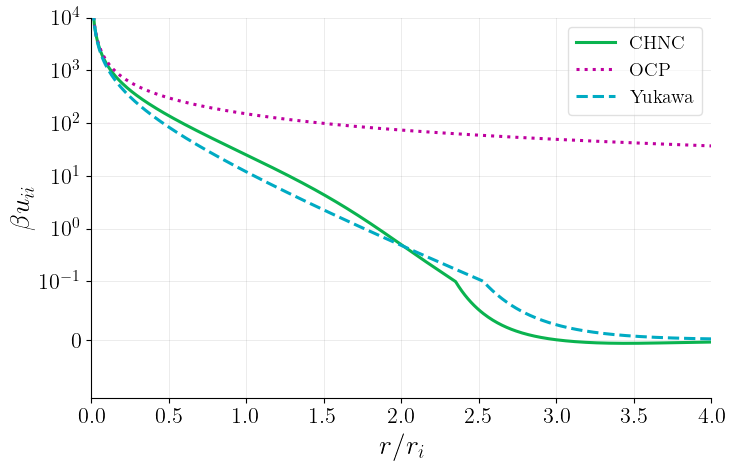

In [20]:
def βu_ii_eff_plot(ax):
    ax.plot(C1_CHNC['r/ri'],C1_CHNC['βu_ii_eff'], label="CHNC"  )
    ax.plot(C1_CHNC['r/ri'],C1_CHNC['βu_OCP'],':', label="OCP"  )
    ax.plot(C1_CHNC['r/ri'],C1_CHNC['βu_Yuk'],'--', label="Yukawa"  )


    ax.set_xlim(0,4)
    ax.set_ylim(-0.1,1e4)
    ax.set_yscale('symlog', linthresh=0.1)
    ax.set_ylabel(r"$\beta u_{ii}$")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()
    
fig, ax  = plt.subplots()
βu_ii_eff_plot(ax)

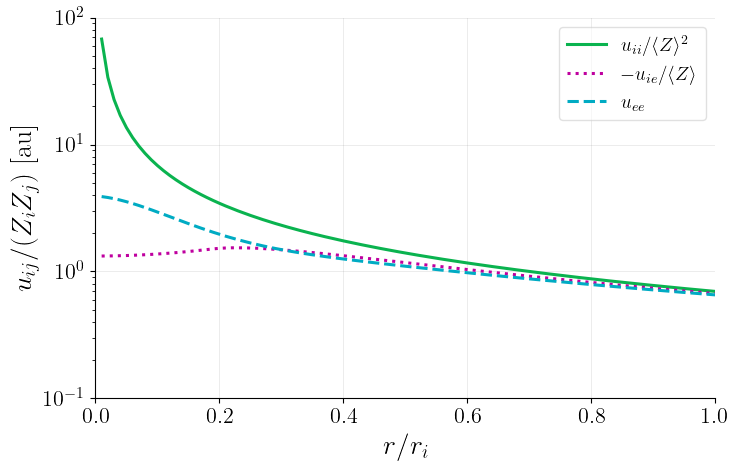

In [24]:
plasma = plasma_list[6]
def βu_ii_plot(ax):
    ax.plot(C1_CHNC['r/ri'], plasma.qsp.Ti*plasma.hnc.βu_r_matrix[0,0]/plasma.Zbar**2, label=r"$u_{ii}/\langle Z\rangle^2$"  )
    ax.plot(C1_CHNC['r/ri'],-plasma.qsp.Tie_c*plasma.hnc.βu_r_matrix[0,1]/plasma.Zbar,':', label=r"$-u_{ie}/\langle Z\rangle$"  )
    ax.plot(C1_CHNC['r/ri'], plasma.qsp.Te_c*plasma.hnc.βu_r_matrix[1,1],'--', label=r"$u_{ee}$"  )

    ax.set_xlim(0,1)
    ax.set_ylim(1e-1,1e2)
    ax.set_yscale('log')
    ax.set_ylabel(r"$u_{ij}/(Z_i Z_j) $ [au]")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()
    
fig, ax  = plt.subplots()
βu_ii_plot(ax)

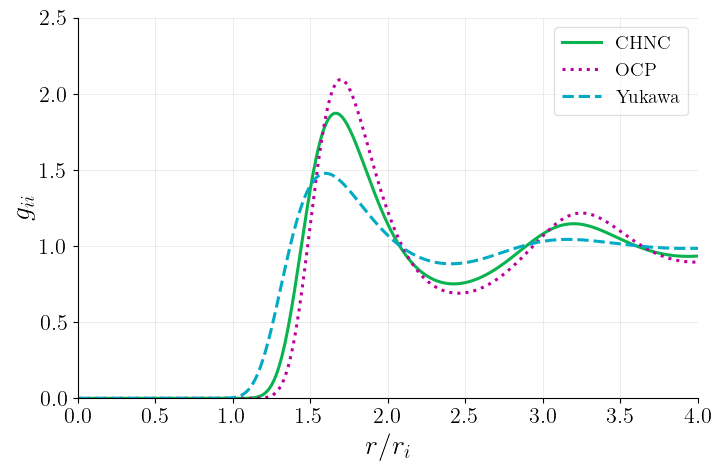

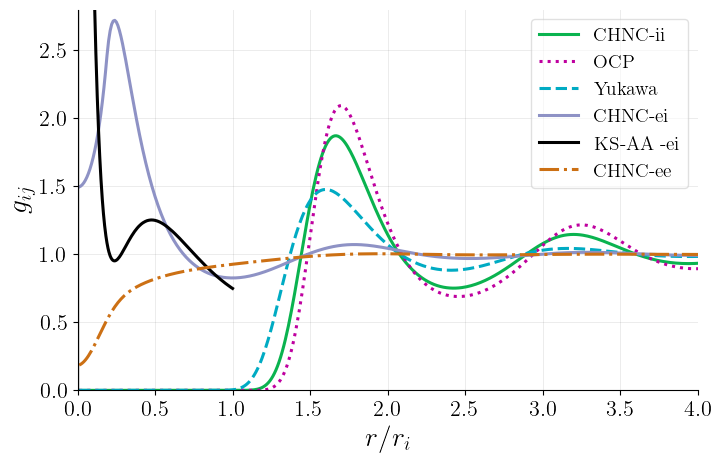

In [25]:
def g_ii_plot(ax):
    ax.plot(C1_CHNC['r/ri'],C1_CHNC['g_ii'], label="CHNC"  )
    ax.plot(C1_CHNC['r/ri'],C1_CHNC['OCP:g_ii'],':', label="OCP"  )
    ax.plot(C1_CHNC['r/ri'],C1_CHNC['Yuk:g_ii'],'--', label="Yukawa"  )


    ax.set_xlim(0,4)
    ax.set_ylim(0,2.5)
    # ax.set_yscale('symlog', linthresh=0.1)
    ax.set_ylabel(r"$g_{ii}$")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()

fig, ax  = plt.subplots( figsize=(8, 4.9443))
g_ii_plot(ax)

def g_ij_plot(ax):
    ax.plot(C1_CHNC['r/ri'],C1_CHNC['g_ii'], label="CHNC-ii"  )
    ax.plot(C1_CHNC['r/ri'],C1_CHNC['OCP:g_ii'],':', label="OCP"  )
    ax.plot(C1_CHNC['r/ri'],C1_CHNC['Yuk:g_ii'],'--', label="Yukawa"  )

    ax.plot(C1_CHNC['r/ri'],C1_CHNC['g_ei'], label="CHNC-ei"  )
    ax.plot(C1_GP['x'], (C1_GP['ne_s']/C1_ne0), 'k-', label="KS-AA -ei "  )

    ax.plot(C1_CHNC['r/ri'],C1_CHNC['g_ee'],'-.', label="CHNC-ee"  )

    ax.set_xlim(0,4)
    ax.set_ylim(0,2.8)
    # ax.set_yscale('symlog', linthresh=0.1)
    ax.set_ylabel(r"$g_{ij}$")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()

fig, ax  = plt.subplots( figsize=(8, 4.9443))
g_ij_plot(ax)

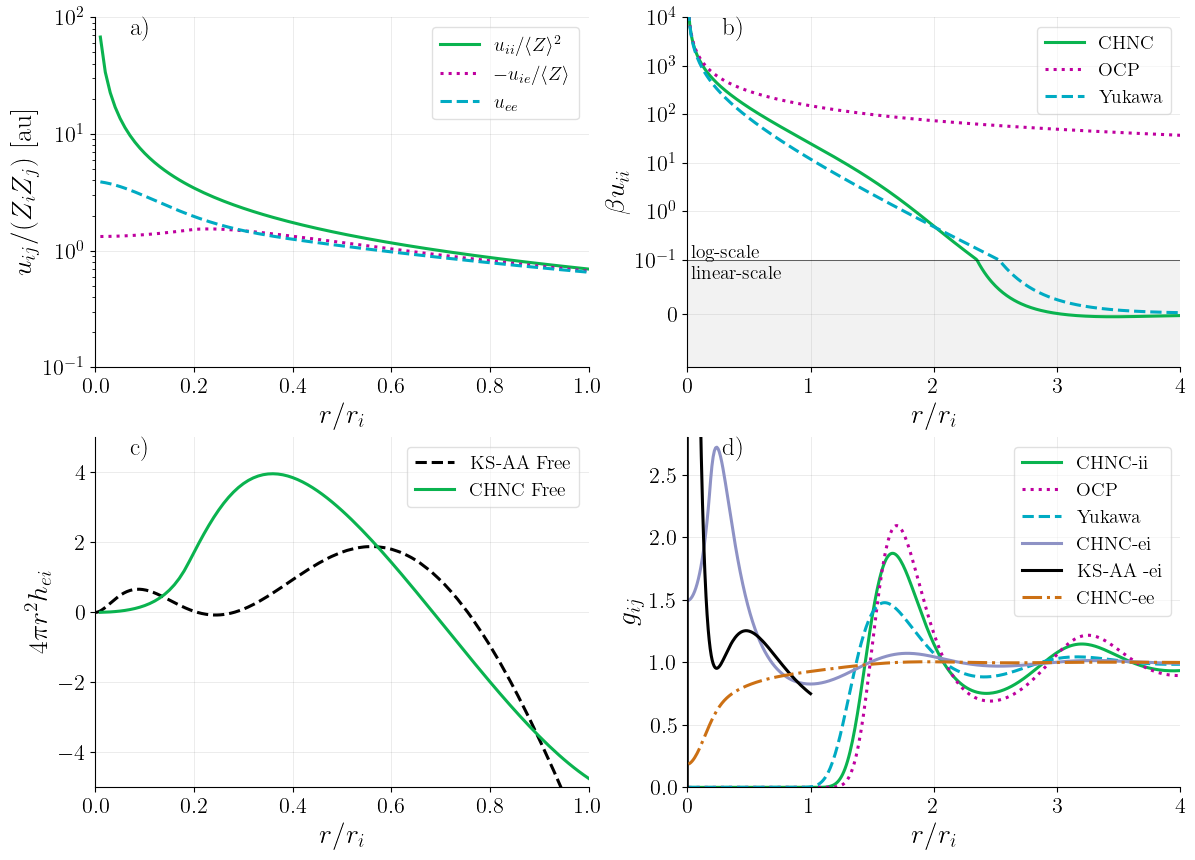

In [26]:
fig, axs = plt.subplots(2,2, figsize=(14, 10))

βu_ii_plot(axs[0,0])
βu_ii_eff_plot(axs[0,1])
g_ei_plot(axs[1,0])
g_ij_plot(axs[1,1])
axs[0,1].axhline(y=0.1,color='k',linewidth=0.4)
axs[0,1].fill_between(np.linspace(0,10),-1,0.1,color='k',alpha=0.05)
axs[0,1].text(0.03, 0.11, "log-scale",fontsize=14)
axs[0,1].text(0.03, 0.065, "linear-scale",fontsize=14)
# Subfigure Labels
axs[0,0].text(0.07, 0.95, "a)", transform=axs[0,0].transAxes, fontsize=18)
axs[0,1].text(0.07, 0.95, "b)", transform=axs[0,1].transAxes, fontsize=18)
axs[1,0].text(0.07, 0.95, "c)", transform=axs[1,0].transAxes, fontsize=18)
axs[1,1].text(0.07, 0.95, "d)", transform=axs[1,1].transAxes, fontsize=18)

plt.savefig("C1_gβu_plot.png", dpi=400)
